<a href="https://colab.research.google.com/github/RiccardoSpolaor/cloud-movement-diffusion/blob/main/3DUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [1]:
from pathlib import Path

def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))

In [2]:
!pip install -q wandb tqdm matplotlib fastprogress torchmetrics diffusers denoising_diffusion_pytorch fastcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 30.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [3]:
import wandb
wandb.login(key='6b22cbf359c5924f4500afc1ae572d6827998186', relogin=True, force=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import wandb
from tqdm import tqdm as progress_bar
import cv2

# from cloud_diffusion.utils import ls

PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:v0'

class DummyNextFrameDataset:
    "Dataset that returns random images"
    def __init__(self, num_frames=4, img_size=64, N=1000):
        self.img_size = img_size
        self.num_frames = num_frames
        self.N = N

    def __getitem__(self, idx):
        return torch.randn(self.num_frames, self.img_size, self.img_size)
    
    def __len__(self):
        return self.N


class CloudDataset:
    """Dataset for cloud images
    It loads numpy files from wandb artifact and stacks them into a single array
    It also applies some transformations to the images
    """
    def __init__(self, 
                 files, # list of numpy files to load (they come from the artifact)
                 num_frames=4, # how many consecutive frames to stack
                 scale=True, # if we images to interval [-0.5, 0.5]
                 img_size=64, # resize dim, original images are big (446, 780)
                 valid=False, # if True, transforms are deterministic
                ):
        self.means=[]
        self.stds=[]
        tfms = [T.Normalize(self.means, self.stds)]
        tfms += [T.RandomCrop(img_size)] if not valid else [T.CenterCrop(img_size)]
        self.tfms = T.Compose(tfms)
        self.load_data(files, num_frames, scale)

        
    def _scale(self, arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)

    def _calculate_mean_std(self, arr):
        "Calculate mean and std for normalization"
        mean, std = arr.mean(), arr.std()
        self.means.append(mean)
        self.stds.append(std)

    def _resize(self, arr, img_size):
        num_events, num_frames = arr.shape[0], arr.shape[3]
        resized_array = np.empty((num_events, img_size, img_size, num_frames))
        for event in range(num_events):
            resized_array[event] = cv2.resize(arr[event], (img_size, img_size))
        return resized_array.transpose((0, 3, 1, 2))
    
    def load_channel(self, file, scale=True):
        one_channel = np.load(file)
        one_channel = one_channel.astype('float32')
        if scale:
            one_day = 0.5 - self._scale(one_channel)
            self._calculate_mean_std(one_channel)
        return one_channel

    def create_windows(self, data, num_frames):
        windows = []
        for event in data:
            wds = np.lib.stride_tricks.sliding_window_view(
                        event,
                        num_frames,
                        axis=0)[::num_frames].transpose(0,4,1,2,3) # (windows, frames, channels, height, width)
            windows.append(wds)
        windows = np.array(windows)
        shape = windows.shape
        windows = windows.reshape(shape[0] * shape[1], shape[2], shape[3], shape[4], shape[5])
        windows = windows.astype('float32')
        return windows # (batch, channels, frames, height, width)

    def load_data(self, files, num_frames, scale, img_size=64):
        "Loads all data into a single array self.data"
        channels = []
        # Load all channels
        for file in progress_bar(files, leave=False):
            one_channel = self.load_channel(file, scale)
            resized_array = self._resize(one_channel, img_size)
            channels.append(resized_array)
            del one_channel
        all_channels = np.stack(channels, axis=2)
        self.data = self.create_windows(all_channels, num_frames)

    def shuffle(self):
        """Shuffles the dataset, useful for getting 
        interesting samples on the validation dataset"""
        idxs = torch.randperm(len(self.data))
        self.data = self.data[idxs]
        return self

    @staticmethod
    def _scale(arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)
    
    def __getitem__(self, idx):
        return self.tfms(torch.from_numpy(self.data[idx]))
    
    def __len__(self): return len(self.data)

    def save(self, fname="cloud_frames.npy"):
        np.save(fname, self.data)


class CloudDatasetInference(CloudDataset):
     def load_data(self, files, num_frames=None, scale=None):
        "Loads all data into a single array self.data"
        data = []
        max_length = 100
        # TODO: download everything
        for file in files:
            one_day = self.load_day(file, scale)
            data.append(one_day)
            max_length = min(max_length, len(one_day))
        self.data = np.stack([d[:max_length] for d in data], axis=0).squeeze()


def download_dataset(at_name, project_name):
    "Downloads dataset from wandb artifact"
    def _get_dataset(run):
        artifact = run.use_artifact(at_name, type='dataset')
        return artifact.download()

    if wandb.run is not None:
        run = wandb.run
        artifact_dir = _get_dataset(run)
    else:
        run = wandb.init(project=project_name, job_type="download_dataset")
        artifact_dir = _get_dataset(run)
        run.finish()

    files = ls(Path(artifact_dir))
    return files

# Model

In [5]:
import os
import torch
from torch import nn
from torch.autograd import Variable


class ConvGRUCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias, dtype):
        """
        Initialize the ConvLSTM cell
        :param input_size: (int, int)
            Height and width of input tensor as (height, width).
        :param input_dim: int
            Number of channels of input tensor.
        :param hidden_dim: int
            Number of channels of hidden state.
        :param kernel_size: (int, int)
            Size of the convolutional kernel.
        :param bias: bool
            Whether or not to add the bias.
        :param dtype: torch.cuda.FloatTensor or torch.FloatTensor
            Whether or not to use cuda.
        """
        super(ConvGRUCell, self).__init__()
        self.height, self.width = input_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.dtype = dtype

        self.conv_gates = nn.Conv2d(in_channels=input_dim + hidden_dim,
                                    out_channels=2*self.hidden_dim,  # for update_gate,reset_gate respectively
                                    kernel_size=kernel_size,
                                    padding=self.padding,
                                    bias=self.bias)

        self.conv_can = nn.Conv2d(in_channels=input_dim+hidden_dim,
                              out_channels=self.hidden_dim, # for candidate neural memory
                              kernel_size=kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).type(self.dtype))

    def forward(self, input_tensor, h_cur):
        """

        :param self:
        :param input_tensor: (b, c, h, w)
            input is actually the target_model
        :param h_cur: (b, c_hidden, h, w)
            current hidden and cell states respectively
        :return: h_next,
            next hidden state
        """
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv_gates(combined)

        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)

        
        combined = torch.cat([input_tensor, reset_gate*h_cur], dim=1)
        cc_cnm = self.conv_can(combined)
        cnm = torch.tanh(cc_cnm)

        h_next = (1 - update_gate) * h_cur + update_gate * cnm
        return h_next


class ConvGRU(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 dtype, batch_first=False, bias=True, return_all_layers=False):
        """

        :param input_size: (int, int)
            Height and width of input tensor as (height, width).
        :param input_dim: int e.g. 256
            Number of channels of input tensor.
        :param hidden_dim: int e.g. 1024
            Number of channels of hidden state.
        :param kernel_size: (int, int)
            Size of the convolutional kernel.
        :param num_layers: int
            Number of ConvLSTM layers
        :param dtype: torch.cuda.FloatTensor or torch.FloatTensor
            Whether or not to use cuda.
        :param alexnet_path: str
            pretrained alexnet parameters
        :param batch_first: bool
            if the first position of array is batch or not
        :param bias: bool
            Whether or not to add the bias.
        :param return_all_layers: bool
            if return hidden and cell states for all layers
        """
        super(ConvGRU, self).__init__()

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.dtype = dtype
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = input_dim if i == 0 else hidden_dim[i - 1]
            cell_list.append(ConvGRUCell(input_size=(self.height, self.width),
                                         input_dim=cur_input_dim,
                                         hidden_dim=self.hidden_dim[i],
                                         kernel_size=self.kernel_size[i],
                                         bias=self.bias,
                                         dtype=self.dtype))

        # convert python list to pytorch module
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        :param input_tensor: (b, t, c, h, w) or (t,b,c,h,w) depends on if batch first or not
            extracted features from alexnet
        :param hidden_state:
        :return: layer_output_list, last_state_list
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                # input current hidden and cell state then compute the next hidden and cell state through ConvLSTMCell forward function
                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], # (b,t,c,h,w)
                                              h_cur=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [6]:
from typing import Tuple
import torch
from torch import nn

class TemporalEncoder(nn.Module):
    def __init__(
        self, 
        input_size: Tuple[int, int], 
        hidden_size: int,
        num_images: int, 
        device: str
        ) -> None:
        super().__init__()
        # Set the input size of the image.
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Set the size of the flattened image.
        self.flatten_size = input_size[0] * input_size[1]
        # Set a list of GRUs, one for each image.
        self.gru = nn.GRU(
            self.flatten_size, hidden_size, batch_first=True)
        #self.grus = nn.ModuleList(
        #    [nn.GRU(self.flatten_size, self.flatten_size)
        #     for _ in range(num_images)])
        # Set the device used for the computations.
        self.to(device)
        self.device = device

    def to(self, device: str) -> None:
        super().to(device)
        self.device = device

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        batch_size = x.shape[0]
        n_channels = x.shape[1]
        # Set the initial hidden states 
        initial_hidden_state = torch.zeros(
            batch_size, n_channels, self.hidden_size, dtype=torch.float32,
            device=self.device)

        _, out = self.gru(x.flatten(start_dim=2), initial_hidden_state)
        # Iterate over the images and pass them through the GRUs.
        '''for i, gru in enumerate(self.grus):
            # Flatten the image.
            img = x[:, i].flatten(start_dim=1)
            # If it is the first image, use the initial hidden state.
            if i == 0:
                h = initial_hidden_state
            # Get the forward pass of the GRU.
            h, _ = gru(img, h)''';
        
        """# Turn the hidden state to the original shape.
        out = out.view(batch_size, n_channels, self.input_size[0],
                       self.input_size[1])"""
        return out

In [7]:
from pathlib import Path

import wandb
import fastcore.all as fc

import torch
from torch import nn
from diffusers import UNet2DModel

try:
    from denoising_diffusion_pytorch.simple_diffusion import UViT
except:
    raise ImportError("Please install denoising_diffusion_pytorch with `pip install denoising_diffusion_pytorch`")

def init_unet(model):
    "From Jeremy's bag of tricks on fastai V2 2023"
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): nn.init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

class WandbModel:
    "A model that can be saved to wandb"
    @classmethod
    def from_checkpoint(cls, model_params, checkpoint_file):
        "Load a UNet2D model from a checkpoint file"
        model = cls(**model_params)
        print(f"Loading model from: {checkpoint_file}")
        model.load_state_dict(torch.load(checkpoint_file))
        return model

    @classmethod
    def from_artifact(cls, model_params, artifact_name):
        "Load a UNet2D model from a wandb.Artifact, need to be run in a wandb run"
        artifact = wandb.use_artifact(artifact_name, type='model')
        artifact_dir = Path(artifact.download())
        chpt_file = list(artifact_dir.glob("*.pth"))[0]
        return cls.from_checkpoint(model_params, chpt_file)

def get_unet_params(model_name="unet_small", num_frames=4):
    "Return the parameters for the diffusers UNet2d model"
    if model_name == "unet_small":
        return dict(
            block_out_channels=(16, 32, 64, 128), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=4, # number of input channels
            out_channels=1, # number of output channels
            input_size=(1, 64, 64),
            hidden_size=3,
            num_images=3,
            )
    elif model_name == "unet_big":
        return dict(
            block_out_channels=(32, 64, 128, 256), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    elif model_name == "unet_3d":
        return dict(
            in_channels=(1, 64, 64), # number of input channels
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'unet_small' or 'unet_big'")

class UNet2DTemporalCondition(UNet2DModel, WandbModel):
    def __init__(self, 
                 *x, 
                 input_size: Tuple[int, int, int], 
                 hidden_size: Tuple[int, int], 
                 num_images: int, 
                 device: str = "cuda",
                 **kwargs):
        super().__init__(*x, **kwargs)
        init_unet(self)
        self.temporal_encoder = ConvGRU(input_size=(input_size[1, 2]),
                                        input_dim=input_size[0],
                                        hidden_dim=hidden_size,
                                        kernel_size=(3, 3),
                                        num_layers=2,
                                        dtype=torch.cuda.FloatTensor,
                                        batch_first=True,
                                        bias = True,
                                        return_all_layers = False).to(device)

    def forward(self, *x, **kwargs):
        temporal_input = x[0] # first three images
        _, encoder_hidden_states = self.temporal_encoder(temporal_input.to(self.device))
        
        conv_lstm_features = encoder_hidden_states[0][0].to(self.device)
        noisy_frame = x[1]
        noise_hidden_state = torch.cat([conv_lstm_features, noisy_frame], dim=1)

        return super().forward(noise_hidden_state, timestep=x[2], **kwargs).sample ## Diffusers's UNet2DConditionModel class

## Simple Diffusion paper

def get_uvit_params(model_name="uvit_small", num_frames=4):
    "Return the parameters for the diffusers UViT model"
    if model_name == "uvit_small":
        return dict(
            dim=512,
            ff_mult=2,
            vit_depth=4,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    elif model_name == "uvit_big":
        return dict(
            dim=1024,
            ff_mult=4,
            vit_depth=8,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'uvit_small' or 'uvit_big'")

class UViTModel(UViT, WandbModel): pass

In [8]:
from pathlib import Path

import torch
import wandb
import numpy as np

## For Training

def to_wandb_image(img):
    "Convert a tensor to a wandb.Image"
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

def log_images(xt, samples):
    "Log sampled images to wandb"
    device = samples.device
    frames = torch.cat([xt[:, :-1,...].to(device), samples], dim=1)
    wandb.log({"sampled_images": [to_wandb_image(img) for img in frames]})

def save_model(model, model_name):
    "Save the model to wandb"
    model_name = f"{wandb.run.id}_{model_name}"
    models_folder = Path("models")
    if not models_folder.exists():
        models_folder.mkdir()
    torch.save(model.state_dict(), models_folder/f"{model_name}.pth")
    at = wandb.Artifact(model_name, type="model")
    at.add_file(f"models/{model_name}.pth")
    wandb.log_artifact(at)

## For Inference
def htile(img):
    "Horizontally tile a batch of images."
    return torch.cat(img.split(1), dim=-1)

def vtile(img):
    "Vertically tile a batch of images."
    return torch.cat(img.split(1), dim=-2)

def vhtile(*imgs):
    "Vertically and horizontally tile a batch of images."
    return vtile(torch.cat([htile(img) for img in imgs], dim=0))

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    "Preprocess frames for wandb.Video"
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

In [16]:
import math
import functools
from operator import mul

import torch
import torch.nn.functional as F
from torch import nn, einsum

from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def mul_reduce(tup):
    return functools.reduce(mul, tup)

def divisible_by(numer, denom):
    return (numer % denom) == 0

mlist = nn.ModuleList

# for time conditioning

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.theta = theta
        self.dim = dim

    def forward(self, x):
        dtype, device = x.dtype, x.device
        assert dtype == torch.float, 'input to sinusoidal pos emb must be a float type'

        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device = device, dtype = dtype) * -emb)
        emb = rearrange(x, 'i -> i 1') * rearrange(emb, 'j -> 1 j')
        return torch.cat((emb.sin(), emb.cos()), dim = -1).type(dtype)

# layernorm 3d

class ChanLayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(dim, 1, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim = 1, unbiased = False, keepdim = True)
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) * var.clamp(min = eps).rsqrt() * self.g

# feedforward

def shift_token(t):
    t, t_shift = t.chunk(2, dim = 1)
    t_shift = F.pad(t_shift, (0, 0, 0, 0, 1, -1), value = 0.)
    return torch.cat((t, t_shift), dim = 1)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim = 1)
        return x * F.gelu(gate)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()

        inner_dim = int(dim * mult * 2 / 3)
        self.proj_in = nn.Sequential(
            nn.Conv3d(dim, inner_dim * 2, 1, bias = False),
            GEGLU()
        )

        self.proj_out = nn.Sequential(
            ChanLayerNorm(inner_dim),
            nn.Conv3d(inner_dim, dim, 1, bias = False)
        )

    def forward(self, x, enable_time = True):
        x = self.proj_in(x)

        if enable_time:
            x = shift_token(x)

        return self.proj_out(x)

# best relative positional encoding

class ContinuousPositionBias(nn.Module):
    """ from https://arxiv.org/abs/2111.09883 """

    def __init__(
        self,
        *,
        dim,
        heads,
        num_dims = 1,
        layers = 2
    ):
        super().__init__()
        self.num_dims = num_dims

        self.net = nn.ModuleList([])
        self.net.append(nn.Sequential(nn.Linear(self.num_dims, dim), nn.SiLU()))

        for _ in range(layers - 1):
            self.net.append(nn.Sequential(nn.Linear(dim, dim), nn.SiLU()))

        self.net.append(nn.Linear(dim, heads))

    @property
    def device(self):
        return next(self.parameters()).device
    
    def forward(self, *dimensions):
        device = self.device

        shape = torch.tensor(dimensions, device = device)
        rel_pos_shape = 2 * shape - 1

        # calculate strides

        strides = torch.flip(rel_pos_shape, (0,)).cumprod(dim = -1)
        strides = torch.flip(F.pad(strides, (1, -1), value = 1), (0,))

        # get all positions and calculate all the relative distances

        positions = [torch.arange(d, device = device) for d in dimensions]
        grid = torch.stack(torch.meshgrid(*positions, indexing = 'ij'), dim = -1)
        grid = rearrange(grid, '... c -> (...) c')
        rel_dist = rearrange(grid, 'i c -> i 1 c') - rearrange(grid, 'j c -> 1 j c')

        # get all relative positions across all dimensions

        rel_positions = [torch.arange(-d + 1, d, device = device) for d in dimensions]
        rel_pos_grid = torch.stack(torch.meshgrid(*rel_positions, indexing = 'ij'), dim = -1)
        rel_pos_grid = rearrange(rel_pos_grid, '... c -> (...) c')

        # mlp input

        bias = rel_pos_grid.float()

        for layer in self.net:
            bias = layer(bias)

        # convert relative distances to indices of the bias

        rel_dist += (shape - 1)  # make sure all positive
        rel_dist *= strides
        rel_dist_indices = rel_dist.sum(dim = -1)

        # now select the bias for each unique relative position combination

        bias = bias[rel_dist_indices]
        return rearrange(bias, 'i j h -> h i j')

# helper classes

class Attention(nn.Module):
    def __init__(
        self,
        dim,
        dim_head = 64,
        heads = 8
    ):
        super().__init__()
        self.heads = heads
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads

        self.norm = nn.LayerNorm(dim)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

        nn.init.zeros_(self.to_out.weight.data) # identity with skip connection

    def forward(
        self,
        x,
        rel_pos_bias = None
    ):

        x = self.norm(x)

        q, k, v = self.to_q(x), *self.to_kv(x).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), (q, k, v))

        q = q * self.scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k)

        if exists(rel_pos_bias):
            sim = sim + rel_pos_bias

        attn = sim.softmax(dim = -1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# main contribution - pseudo 3d conv

class PseudoConv3d(nn.Module):
    def __init__(
        self,
        dim,
        dim_out = None,
        kernel_size = 3,
        *,
        temporal_kernel_size = None,
        **kwargs
    ):
        super().__init__()
        dim_out = default(dim_out, dim)
        temporal_kernel_size = default(temporal_kernel_size, kernel_size)

        self.spatial_conv = nn.Conv2d(dim, dim_out, kernel_size = kernel_size, padding = kernel_size // 2)
        self.temporal_conv = nn.Conv1d(dim_out, dim_out, kernel_size = temporal_kernel_size, padding = temporal_kernel_size // 2) if kernel_size > 1 else None

        if exists(self.temporal_conv):
            nn.init.dirac_(self.temporal_conv.weight.data) # initialized to be identity
            nn.init.zeros_(self.temporal_conv.bias.data)

    def forward(
        self,
        x,
        enable_time = True
    ):
        b, c, *_, h, w = x.shape

        is_video = x.ndim == 5
        enable_time &= is_video

        if is_video:
            x = rearrange(x, 'b c f h w -> (b f) c h w')

        x = self.spatial_conv(x)

        if is_video:
            x = rearrange(x, '(b f) c h w -> b c f h w', b = b)

        if not enable_time or not exists(self.temporal_conv):
            return x

        x = rearrange(x, 'b c f h w -> (b h w) c f')

        x = self.temporal_conv(x)

        x = rearrange(x, '(b h w) c f -> b c f h w', h = h, w = w)

        return x

# factorized spatial temporal attention from Ho et al.

class SpatioTemporalAttention(nn.Module):
    def __init__(
        self,
        dim,
        *,
        dim_head = 64,
        heads = 8,
        add_feed_forward = True,
        ff_mult = 4
    ):
        super().__init__()
        self.spatial_attn = Attention(dim = dim, dim_head = dim_head, heads = heads)
        self.spatial_rel_pos_bias = ContinuousPositionBias(dim = dim // 2, heads = heads, num_dims = 2)

        self.temporal_attn = Attention(dim = dim, dim_head = dim_head, heads = heads)
        self.temporal_rel_pos_bias = ContinuousPositionBias(dim = dim // 2, heads = heads, num_dims = 1)

        self.has_feed_forward = add_feed_forward
        if not add_feed_forward:
            return

        self.ff = FeedForward(dim = dim, mult = ff_mult)

    def forward(
        self,
        x,
        enable_time = True
    ):
        b, c, *_, h, w = x.shape
        is_video = x.ndim == 5
        enable_time &= is_video

        if is_video:
            x = rearrange(x, 'b c f h w -> (b f) (h w) c')
        else:
            x = rearrange(x, 'b c h w -> b (h w) c')

        space_rel_pos_bias = self.spatial_rel_pos_bias(h, w)

        x = self.spatial_attn(x, rel_pos_bias = space_rel_pos_bias) + x

        if is_video:
            x = rearrange(x, '(b f) (h w) c -> b c f h w', b = b, h = h, w = w)
        else:
            x = rearrange(x, 'b (h w) c -> b c h w', h = h, w = w)

        if enable_time:

            x = rearrange(x, 'b c f h w -> (b h w) f c')

            time_rel_pos_bias = self.temporal_rel_pos_bias(x.shape[1])

            x = self.temporal_attn(x, rel_pos_bias = time_rel_pos_bias) + x

            x = rearrange(x, '(b h w) f c -> b c f h w', w = w, h = h)

        if self.has_feed_forward:
            x = self.ff(x, enable_time = enable_time) + x

        return x

# resnet block

class Block(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        kernel_size = 3,
        temporal_kernel_size = None,
        groups = 8
    ):
        super().__init__()
        self.project = PseudoConv3d(dim, dim_out, 3)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(
        self,
        x,
        scale_shift = None,
        enable_time = False
    ):
        x = self.project(x, enable_time = enable_time)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        return self.act(x)

class ResnetBlock(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        timestep_cond_dim = None,
        groups = 8
    ):
        super().__init__()

        self.timestep_mlp = None

        if exists(timestep_cond_dim):
            self.timestep_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(timestep_cond_dim, dim_out * 2)
            )

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = PseudoConv3d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(
        self,
        x,
        timestep_emb = None,
        enable_time = True
    ):
        assert not (exists(timestep_emb) ^ exists(self.timestep_mlp))

        scale_shift = None

        if exists(self.timestep_mlp) and exists(timestep_emb):
            time_emb = self.timestep_mlp(timestep_emb)
            to_einsum_eq = 'b c 1 1 1' if x.ndim == 5 else 'b c 1 1'
            time_emb = rearrange(time_emb, f'b c -> {to_einsum_eq}')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift, enable_time = enable_time)

        h = self.block2(h, enable_time = enable_time)

        return h + self.res_conv(x)

# pixelshuffle upsamples and downsamples
# where time dimension can be configured

class Downsample(nn.Module):
    def __init__(
        self,
        dim,
        downsample_space = True,
        downsample_time = False,
        nonlin = False
    ):
        super().__init__()
        assert downsample_space or downsample_time

        self.down_space = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = 2, p2 = 2),
            nn.Conv2d(dim * 4, dim, 1, bias = False),
            nn.SiLU() if nonlin else nn.Identity()
        ) if downsample_space else None

        self.down_time = nn.Sequential(
            Rearrange('b c (f p) h w -> b (c p) f h w', p = 2),
            nn.Conv3d(dim * 2, dim, 1, bias = False),
            nn.SiLU() if nonlin else nn.Identity()
        ) if downsample_time else None

    def forward(
        self,
        x,
        enable_time = True
    ):
        is_video = x.ndim == 5

        if is_video:
            x = rearrange(x, 'b c f h w -> b f c h w')
            x, ps = pack([x], '* c h w')

        if exists(self.down_space):
            x = self.down_space(x)

        if is_video:
            x, = unpack(x, ps, '* c h w')
            x = rearrange(x, 'b f c h w -> b c f h w')

        if not is_video or not exists(self.down_time) or not enable_time:
            return x

        x = self.down_time(x)

        return x

class Upsample(nn.Module):
    def __init__(
        self,
        dim,
        upsample_space = True,
        upsample_time = False,
        nonlin = False
    ):
        super().__init__()
        assert upsample_space or upsample_time

        self.up_space = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            nn.SiLU() if nonlin else nn.Identity(),
            Rearrange('b (c p1 p2) h w -> b c (h p1) (w p2)', p1 = 2, p2 = 2)
        ) if upsample_space else None

        self.up_time = nn.Sequential(
            nn.Conv3d(dim, dim * 2, 1),
            nn.SiLU() if nonlin else nn.Identity(),
            Rearrange('b (c p) f h w -> b c (f p) h w', p = 2)
        ) if upsample_time else None

        self.init_()

    def init_(self):
        if exists(self.up_space):
            self.init_conv_(self.up_space[0], 4)

        if exists(self.up_time):
            self.init_conv_(self.up_time[0], 2)

    def init_conv_(self, conv, factor):
        o, *remain_dims = conv.weight.shape
        conv_weight = torch.empty(o // factor, *remain_dims)
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = repeat(conv_weight, 'o ... -> (o r) ...', r = factor)

        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(
        self,
        x,
        enable_time = True
    ):
        is_video = x.ndim == 5

        if is_video:
            x = rearrange(x, 'b c f h w -> b f c h w')
            x, ps = pack([x], '* c h w')

        if exists(self.up_space):
            x = self.up_space(x)

        if is_video:
            x, = unpack(x, ps, '* c h w')
            x = rearrange(x, 'b f c h w -> b c f h w')

        if not is_video or not exists(self.up_time) or not enable_time:
            return x

        x = self.up_time(x)

        return x

# space time factorized 3d unet

class SpaceTimeUnet(nn.Module):
    def __init__(
        self,
        *,
        dim,
        channels = 3,
        dim_mult = (1, 2, 4, 8),
        self_attns = (False, False, False, True),
        temporal_compression = (False, True, True, True),
        resnet_block_depths = (2, 2, 2, 2),
        attn_dim_head = 64,
        attn_heads = 8,
        condition_on_timestep = True
    ):
        super().__init__()
        assert len(dim_mult) == len(self_attns) == len(temporal_compression) == len(resnet_block_depths)
        num_layers = len(dim_mult)

        dims = [dim, *map(lambda mult: mult * dim, dim_mult)]
        dim_in_out = zip(dims[:-1], dims[1:])

        # determine the valid multiples of the image size and frames of the video

        self.frame_multiple = 2 ** sum(tuple(map(int, temporal_compression)))
        self.image_size_multiple = 2 ** num_layers

        # timestep conditioning for DDPM, not to be confused with the time dimension of the video

        self.to_timestep_cond = None
        timestep_cond_dim = (dim * 4) if condition_on_timestep else None

        if condition_on_timestep:
            self.to_timestep_cond = nn.Sequential(
                SinusoidalPosEmb(dim),
                nn.Linear(dim, timestep_cond_dim),
                nn.SiLU()
            )

        # layers

        self.downs = mlist([])
        self.ups = mlist([])

        attn_kwargs = dict(
            dim_head = attn_dim_head,
            heads = attn_heads
        )

        mid_dim = dims[-1]

        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, timestep_cond_dim = timestep_cond_dim)
        self.mid_attn = SpatioTemporalAttention(dim = mid_dim)
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, timestep_cond_dim = timestep_cond_dim)

        for _, self_attend, (dim_in, dim_out), compress_time, resnet_block_depth in zip(range(num_layers), self_attns, dim_in_out, temporal_compression, resnet_block_depths):
            assert resnet_block_depth >= 1

            self.downs.append(mlist([
                ResnetBlock(dim_in, dim_out, timestep_cond_dim = timestep_cond_dim),
                mlist([ResnetBlock(dim_out, dim_out) for _ in range(resnet_block_depth)]),
                SpatioTemporalAttention(dim = dim_out, **attn_kwargs) if self_attend else None,
                Downsample(dim_out, downsample_time = compress_time)
            ]))

            self.ups.append(mlist([
                ResnetBlock(dim_out * 2, dim_in, timestep_cond_dim = timestep_cond_dim),
                mlist([ResnetBlock(dim_in + (dim_out if ind == 0 else 0), dim_in) for ind in range(resnet_block_depth)]),
                SpatioTemporalAttention(dim = dim_in, **attn_kwargs) if self_attend else None,
                Upsample(dim_out, upsample_time = compress_time) #  = compress_time) fix it better
            ]))

        self.skip_scale = 2 ** -0.5 # paper shows faster convergence

        self.conv_in = PseudoConv3d(dim = channels, dim_out = dim, kernel_size = 7, temporal_kernel_size = 3)
        self.conv_out = PseudoConv3d(dim = dim, dim_out = channels, kernel_size = 3, temporal_kernel_size = 3)
        self.time_conv = nn.Conv3d(8, 4, kernel_size=1, bias=False)

    def forward(
        self,
        x,
        timestep = None,
        enable_time = True
    ):

        # some asserts

        assert not (exists(self.to_timestep_cond) ^ exists(timestep))
        is_video = x.ndim == 5

        if enable_time and is_video:
            frames = x.shape[2]
            assert divisible_by(frames, self.frame_multiple), f'number of frames on the video ({frames}) must be divisible by the frame multiple ({self.frame_multiple})'

        height, width = x.shape[-2:]
        assert divisible_by(height, self.image_size_multiple) and divisible_by(width, self.image_size_multiple), f'height and width of the image or video must be a multiple of {self.image_size_multiple}'

        # main logic

        t = self.to_timestep_cond(rearrange(timestep, '... -> (...)')) if exists(timestep) else None

        x = self.conv_in(x, enable_time = enable_time)

        hiddens = []

        for init_block, blocks, maybe_attention, downsample in self.downs:
            x = init_block(x, t, enable_time = enable_time)
            hiddens.append(x.clone())
            
            for block in blocks:
                x = block(x, enable_time = enable_time)
            if exists(maybe_attention):
                x = maybe_attention(x, enable_time = enable_time)
            hiddens.append(x.clone())

            x = downsample(x, enable_time = enable_time)
            
        x = self.mid_block1(x, t, enable_time = enable_time)
        x = self.mid_attn(x, enable_time = enable_time)
        x = self.mid_block2(x, t, enable_time = enable_time)

        for init_block, blocks, maybe_attention, upsample in reversed(self.ups):
            x = upsample(x, enable_time = enable_time)

            x = torch.cat((hiddens.pop() * self.skip_scale, x), dim = 1)

            x = init_block(x, t, enable_time = enable_time)

            x = torch.cat((hiddens.pop() * self.skip_scale, x), dim = 1)

            for block in blocks:
                x = block(x, enable_time = enable_time)

            if exists(maybe_attention):
                x = maybe_attention(x, enable_time = enable_time)
        x = self.conv_out(x, enable_time = enable_time)
        x = x.permute(0,2,1,3,4)
        x = self.time_conv(x)
        x = x.permute(0,2,1,3,4)
        return x

In [10]:
class UNet3DSpaceTime(nn.Module, WandbModel):
    def __init__(self, 
                 *x, 
                 input_size: Tuple[int, int, int], 
                 device: str = "cuda",
                 **kwargs):
        super().__init__(*x, **kwargs)
        self.unet = SpaceTimeUnet(dim = 64,
                                  channels = input_size[0],
                                  dim_mult = (1, 2, 4, 8),
                                  temporal_compression = (False, False, False, True),
                                  self_attns = (False, False, False, True),
                                  condition_on_timestep = False)

    def forward(self, *x, **kwargs):
        temporal_input = x[0] # first 4 images
        noisy_frames = x[1].unsqueeze(2)
        input = torch.cat([temporal_input, noisy_frames], dim=1)        
        input = input.permute((0,2,1,3,4))
        out = self.unet(input)
        out = out.permute(0,2,1,3,4)
        return out

In [11]:
import random, argparse
from pathlib import Path

import wandb
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data.dataloader import default_collate
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from fastprogress import progress_bar

#from cloud_diffusion.wandb import log_images, save_model

def noisify_last_frames(frames, noise_func, num_frames=4):
    "Noisify the last frame of a sequence"
    past_frames = frames[:,:-num_frames]
    last_frame  = frames[:,-num_frames:,0]
    noise, t, e = noise_func(last_frame)
    # noise = torch.cat([noise] * 3, dim=2)
    return past_frames, noise, t, e

def noisify_collate(noise_func): 
    def _inner(b): 
        "Collate function that noisifies the last frame"
        return noisify_last_frames(default_collate(b), noise_func)
    return _inner

class NoisifyDataloader(DataLoader):
    """Noisify the last frame of a dataloader by applying 
    a noise function, after collating the batch"""
    def __init__(self, dataset, *args, noise_func=None, **kwargs):
        super().__init__(dataset, *args, collate_fn=noisify_collate(noise_func), **kwargs)


In [12]:
from functools import partial

import torch
from fastprogress import progress_bar

from diffusers.schedulers import DDIMScheduler


## DDPM params
## From fastai V2 Course DDPM notebooks
betamin,betamax,n_steps = 0.0001,0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

def noisify_ddpm(x0):
    "Noise by ddpm"
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

@torch.no_grad()
def diffusers_sampler(model, past_frames, sched, **kwargs):
    "Using Diffusers built-in samplers"
    model.eval()
    device = next(model.parameters()).device
    new_frames = torch.randn_like(past_frames, dtype=past_frames.dtype, device=device)
    new_frames = new_frames.squeeze(2)
    preds = []
    pbar = progress_bar(sched.timesteps, leave=False)
    for t in pbar:
        pbar.comment = f"DDIM Sampler: frame {t}"
        noise = model(past_frames, new_frames, t)
        noise = noise.squeeze(2)
        new_frames = sched.step(noise, t, new_frames, **kwargs).prev_sample
        preds.append(new_frames.float().cpu())
    return preds[-1]

def ddim_sampler(steps=350, eta=1.):
    "DDIM sampler, faster and a bit better than the built-in sampler"
    ddim_sched = DDIMScheduler()
    ddim_sched.set_timesteps(steps)
    return partial(diffusers_sampler, sched=ddim_sched, eta=eta)

In [13]:
class MiniTrainer:
    "A mini trainer for the diffusion process"
    def __init__(self, 
                 train_dataloader, 
                 valid_dataloader, 
                 model, 
                 sampler, 
                 device="cuda", 
                 loss_func=nn.MSELoss(), 
                 ):
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.loss_func = loss_func
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        self.model = model.to(device)
        self.scaler = torch.cuda.amp.GradScaler()
        self.device = device
        self.sampler = sampler
        self.val_batch = next(iter(valid_dataloader))
    
    def train_step(self, loss):
        "Train for one step"
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()        
        self.scheduler.step()

    def one_epoch(self, epoch=None):
        "Train for one epoch, log metrics and save model"
        self.model.train()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for batch in pbar:
            past_frames, noise_frame, t, noise = to_device(batch, device=self.device)
            with torch.autocast("cuda"):
                predicted_noise = self.model(past_frames, noise_frame, t)
                loss = self.loss_func(noise.unsqueeze(2), predicted_noise)
            self.train_step(loss)
            wandb.log({"train_mse": loss.item(),
                       "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"epoch={epoch}, MSE={loss.item():2.3f}"

    def one_epoch_validation(self, epoch=None):
        "Validates on val set"
        pbar = progress_bar(self.valid_dataloader, leave=False)
        psnr_metric = 0
        mse_metric = 0
        ssmi_metric = 0
        for val_batch in pbar:
            frames = val_batch[0].to(self.device)
            samples = self.sampler(self.model, past_frames=frames[:,:-1]).to(self.device)
            target = frames[:,-1].unsqueeze(1)
            psnr_metric += self.psnr(samples, target).float().cpu()
            ssmi_metric += self.ssim(samples, target).float().cpu()
            mse_metric += self.loss_func(samples, target).float().cpu()
        psnr_metric = psnr_metric / len(self.valid_dataloader)
        ssmi_metric = ssmi_metric / len(self.valid_dataloader)
        mse_metric = mse_metric / len(self.valid_dataloader)
        wandb.log({"val_psnr": psnr_metric,
                   "val_ssmi": ssmi_metric,
                   "val_mse": mse_metric})

    def prepare(self, config):
        wandb.config.update(config)
        config.total_train_steps = config.epochs * len(self.train_dataloader)
        self.optimizer = AdamW(self.model.parameters(), lr=config.lr, eps=1e-5)
        self.scheduler = OneCycleLR(self.optimizer, max_lr=config.lr, total_steps=config.total_train_steps)

    def fit(self, config):
        self.prepare(config)
        val_past_frames, _, _, _ = to_device(self.val_batch, device=self.device)
        val_past_frames = val_past_frames[:min(config.n_preds, 1)]  # log first prediction
        for epoch in progress_bar(range(config.epochs), total=config.epochs, leave=True):
            self.one_epoch(epoch)
            if config.validate_epochs:
                self.one_epoch_validation(epoch)
            
            # log predictions:
            if epoch % config.log_every_epoch == 0:
                samples = self.sampler(self.model, past_frames=val_past_frames)
                print('samples:', samples.shape)
                import matplotlib.pyplot as plt
                axs = plt.subplots(2, 4, figsize=(10, 10))[1].ravel()
                i=0
                for ax in axs:
                    if i < 4:
                        ax.imshow(val_past_frames[0,i,0].cpu())
                    else:
                        ax.imshow(samples[0,i-4].detach().cpu())
                    ax.axis('off')
                    i+=1
                plt.tight_layout()
                plt.show()    
                # self.one_epoch_validation(epoch)
                # log_images(self.val_batch, samples)

        save_model(self.model, config.model_name)


def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def to_device(t, device="cpu"):
    if isinstance(t, (tuple, list)):
        return [_t.to(device) for _t in t]
    elif isinstance(t, torch.Tensor):
        return t.to(device)
    else:
        raise("Not a Tensor or list of Tensors")


def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))


def parse_args(config):
    "A brute force way to parse arguments, it is probably not a good idea to use it"
    parser = argparse.ArgumentParser(description='Run training baseline')
    for k,v in config.__dict__.items():
        parser.add_argument('--'+k, type=type(v), default=v)
    args = vars(parser.parse_args())
    
    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)

In [14]:
from pathlib import Path
from types import SimpleNamespace

import wandb
import torch
from torch.utils.data import DataLoader

# from cloud_diffusion.dataset import download_dataset, CloudDataset
# from cloud_diffusion.utils import NoisifyDataloader, MiniTrainer, set_seed, parse_args
# from cloud_diffusion.ddpm import noisify_ddpm, ddim_sampler
# from cloud_diffusion.models import UNet2D, get_unet_params


PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:v0'

config = SimpleNamespace(    
    epochs=50, # number of epochs
    model_name="unet_3d", # model name to save [unet_small, unet_big]
    strategy="ddpm", # strategy to use ddpm
    noise_steps=1000, # number of noise steps on the diffusion process
    sampler_steps=333, # number of sampler steps on the diffusion process
    seed=42, # random seed
    batch_size=16, # batch size
    img_size=64, # image size
    device="cuda", # device
    num_workers=2, # number of workers for dataloader
    num_frames=8, # number of frames to use as input
    lr=5e-4, # learning rate
    validation_days=3, # number of days to use for validation
    log_every_epoch=5, # log every n epochs to wandb
    n_preds=8, # number of predictions to make
    validate_epochs=False # compute metrics at each epoch 
    )

def train_func(config, train_ds, val_ds):
    config.model_params = get_unet_params(config.model_name, config.num_frames)

    set_seed(config.seed)
    device = torch.device(config.device)

    # downlaod the dataset from the wandb.Artifact

    # valid_ds = CloudDataset(files=files, num_frames=config.num_frames, img_size=config.img_size).shuffle()

    # DDPM dataloaders
    train_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=True, 
                                         noise_func=noisify_ddpm,  num_workers=config.num_workers)
    valid_dataloader = NoisifyDataloader(val_ds, config.batch_size, shuffle=False, 
                                          noise_func=noisify_ddpm,  num_workers=config.num_workers)

    # model setup
    model = UNet3DSpaceTime(input_size=(1,64,64))

    # sampler
    sampler = ddim_sampler(steps=config.sampler_steps)

    # A simple training loop
    trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)
    trainer.fit(config)

In [ ]:
files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)

In [ ]:
train_ds = CloudDataset(files=files[:1], num_frames=config.num_frames, img_size=config.img_size)

In [19]:
set_seed(config.seed)
device = torch.device(config.device)

# downlaod the dataset from the wandb.Artifact

# valid_ds = CloudDataset(files=files, num_frames=config.num_frames, img_size=config.img_size).shuffle()

# DDPM dataloaders
train_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=True, 
                                      noise_func=noisify_ddpm,  num_workers=config.num_workers)
valid_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=False, 
                                      noise_func=noisify_ddpm,  num_workers=config.num_workers)

# model setup
model = UNet3DSpaceTime(input_size=(1,64,64))

# sampler
sampler = ddim_sampler(steps=333)

# Training

samples: torch.Size([1, 4, 64, 64])


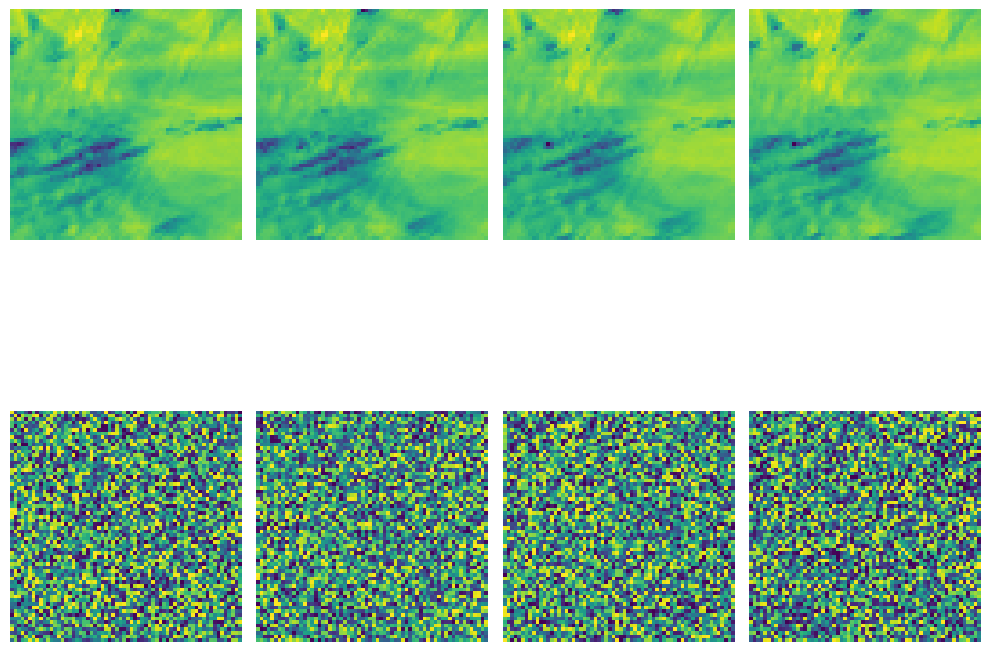

In [ ]:
# A simple training loop
with wandb.init(project='3d_unet', entity='ai-industry', config=config, tags=["ddpm", config.model_name]):
    trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)
    trainer.fit(config)

samples: torch.Size([1, 4, 64, 64])


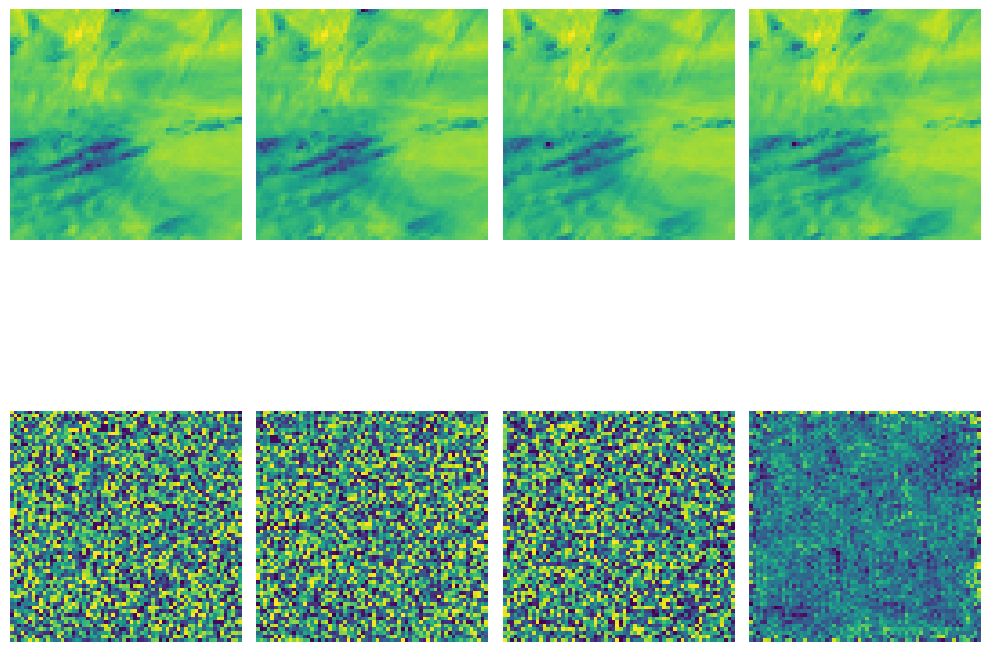

samples: torch.Size([1, 4, 64, 64])


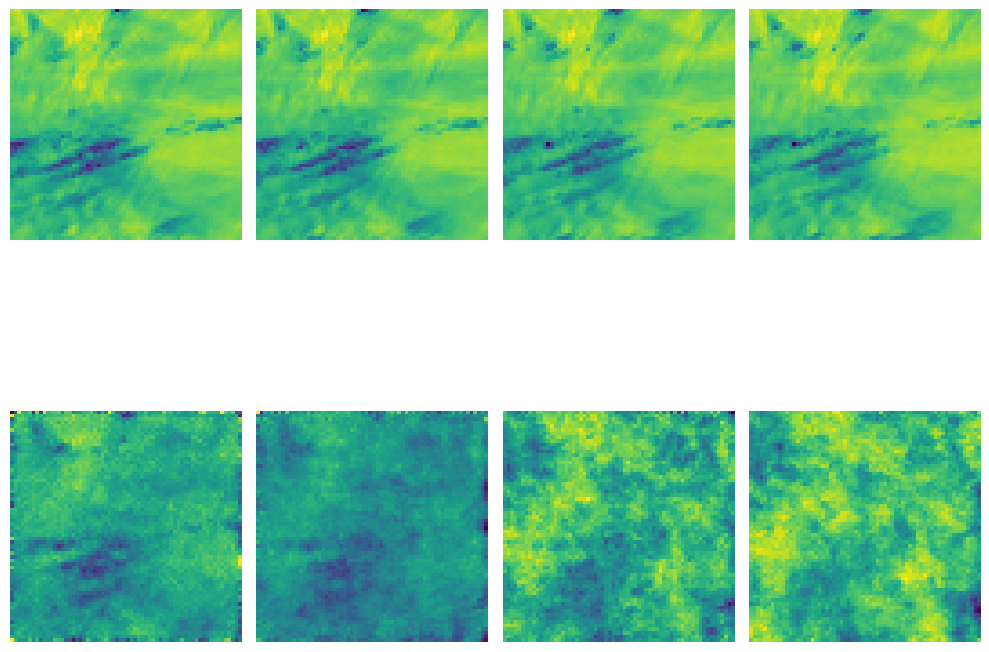

samples: torch.Size([1, 4, 64, 64])


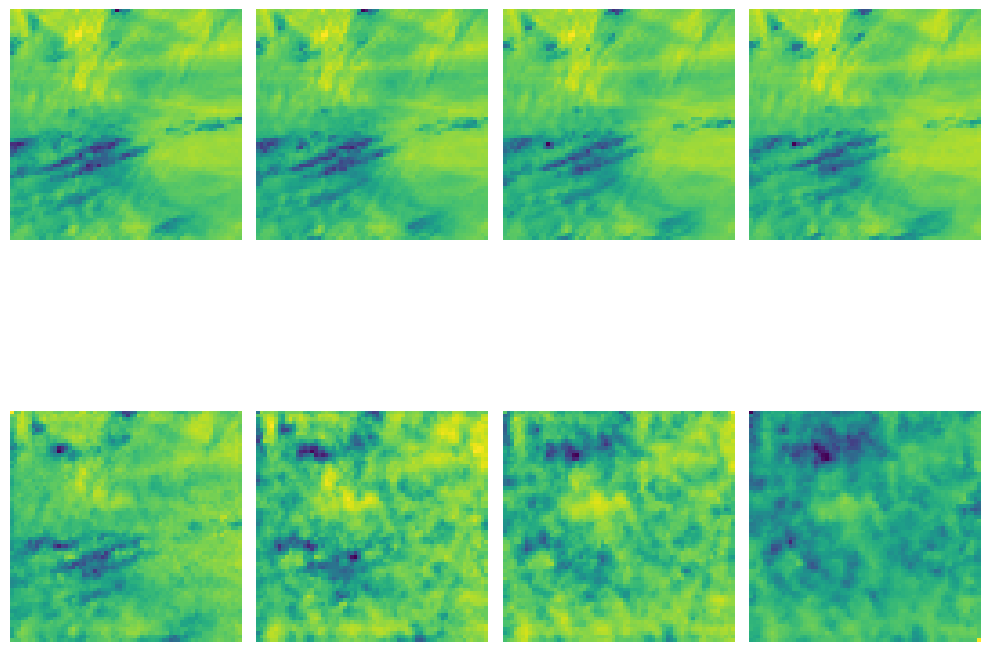

samples: torch.Size([1, 4, 64, 64])


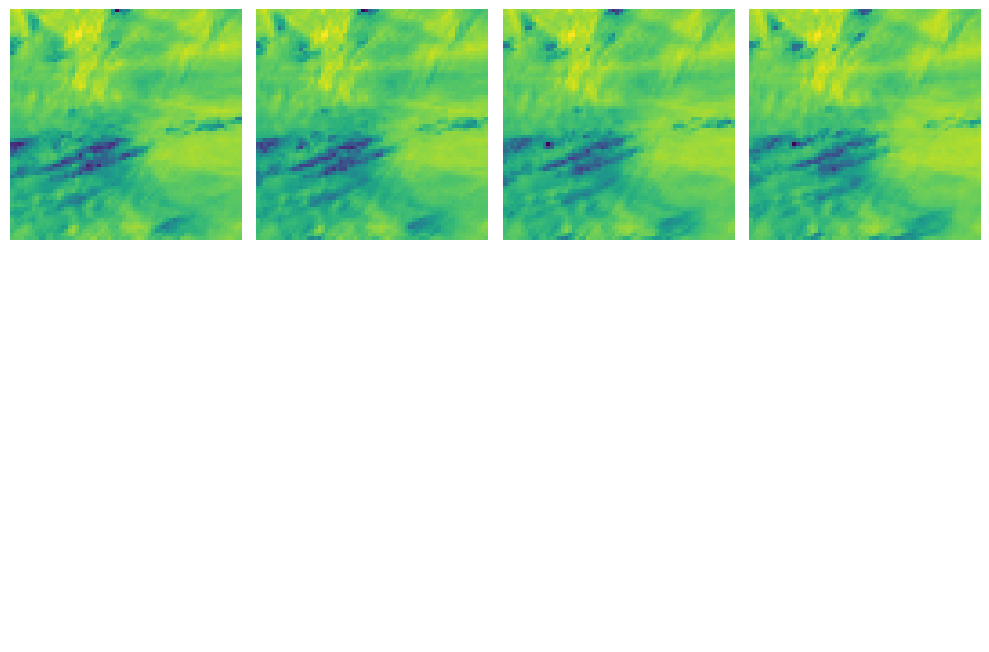

samples: torch.Size([1, 4, 64, 64])


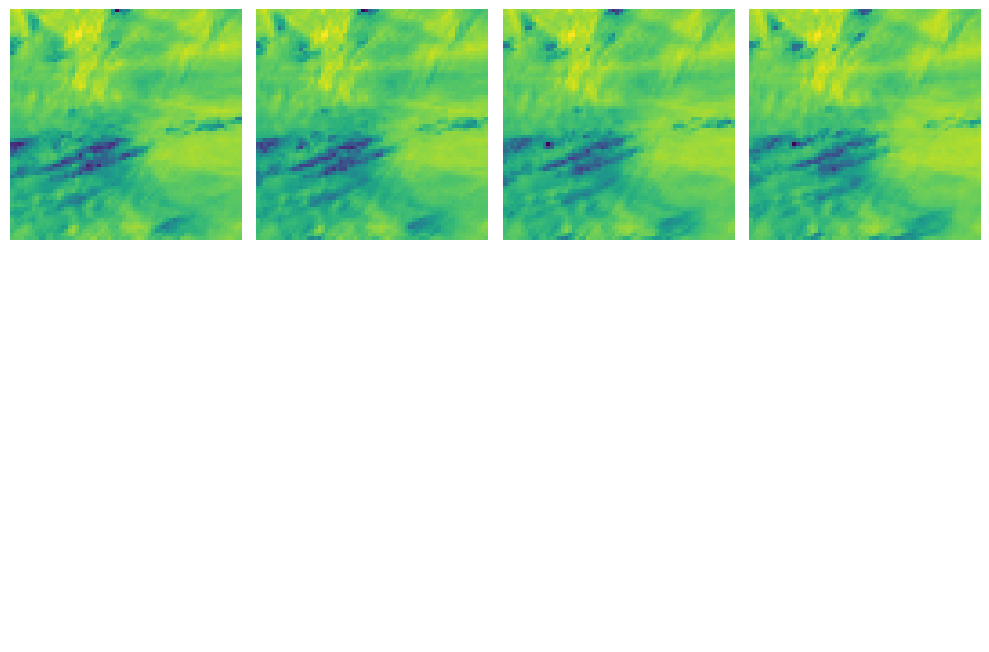

samples: torch.Size([1, 4, 64, 64])


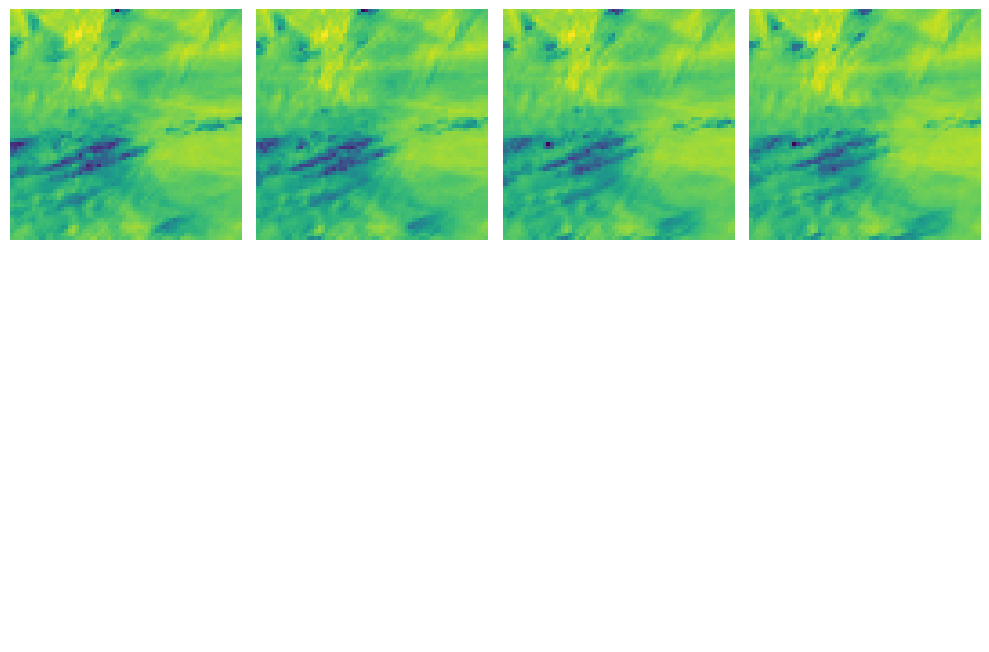

samples: torch.Size([1, 4, 64, 64])


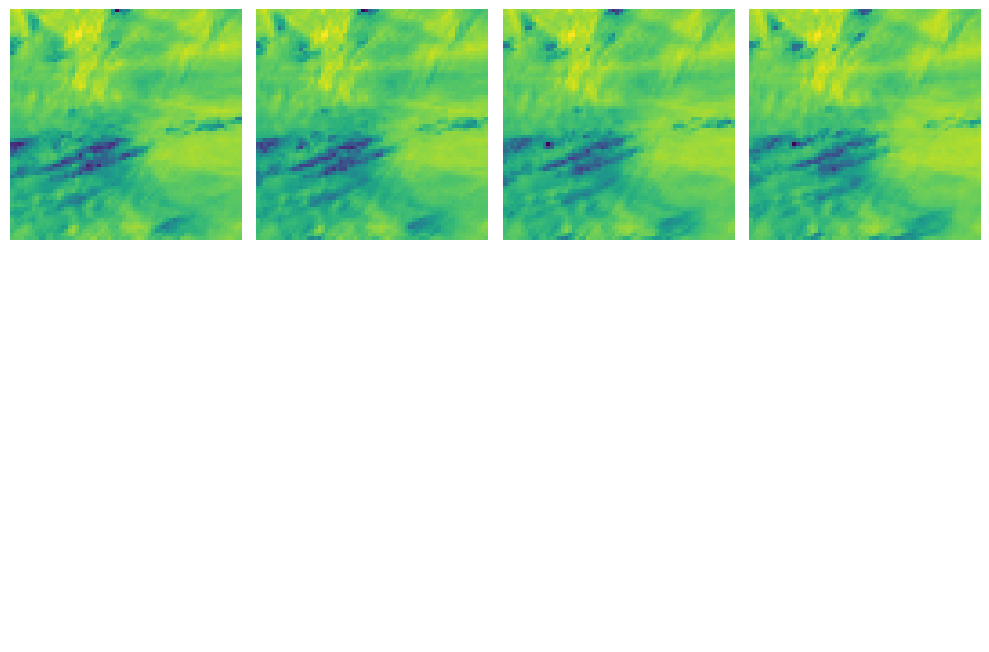

samples: torch.Size([1, 4, 64, 64])


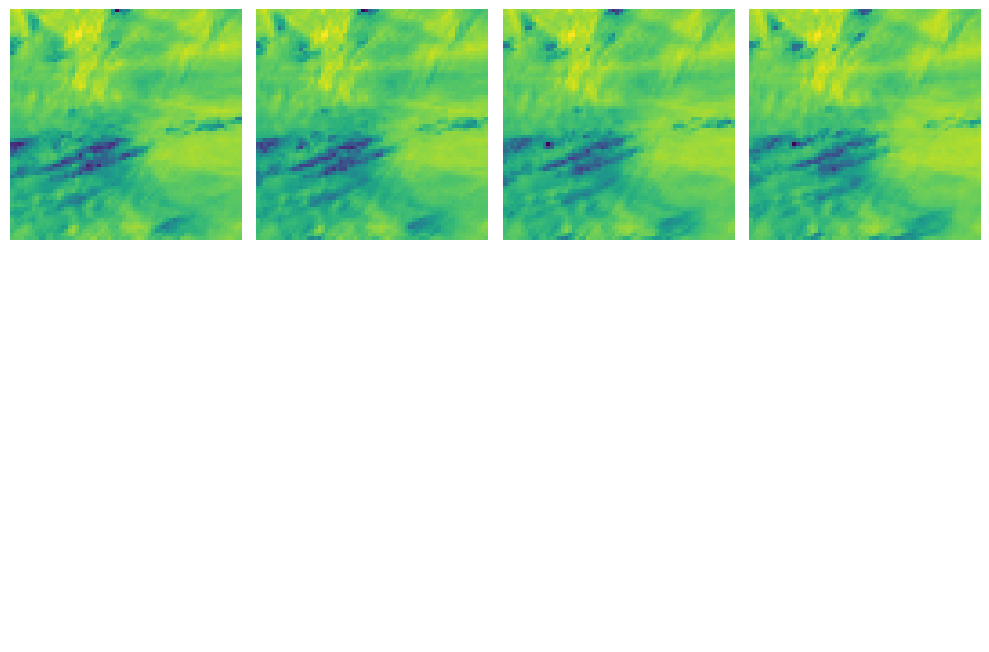

samples: torch.Size([1, 4, 64, 64])


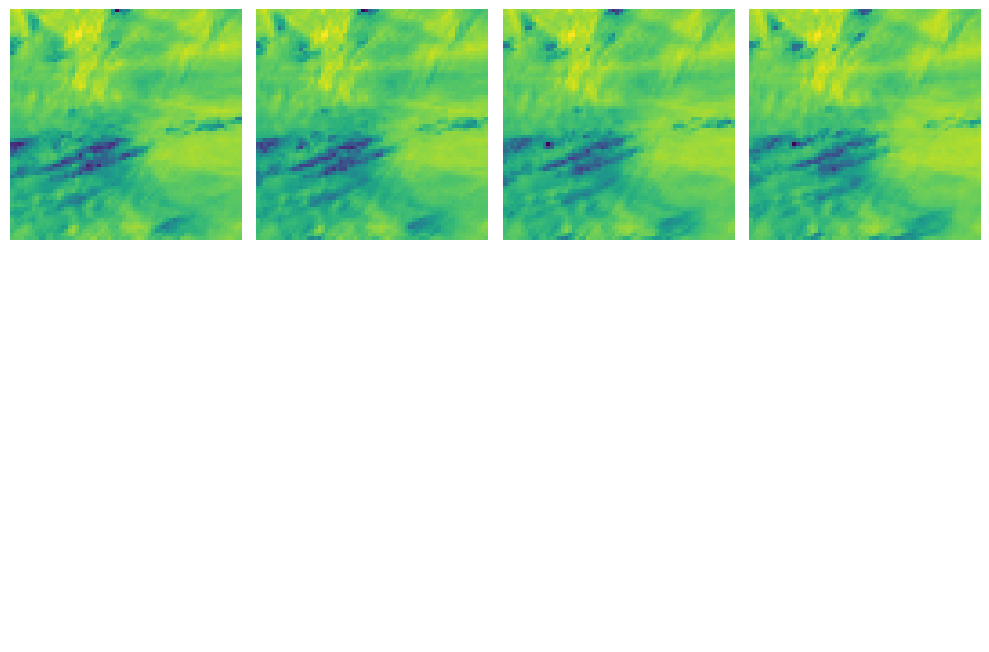

samples: torch.Size([1, 4, 64, 64])


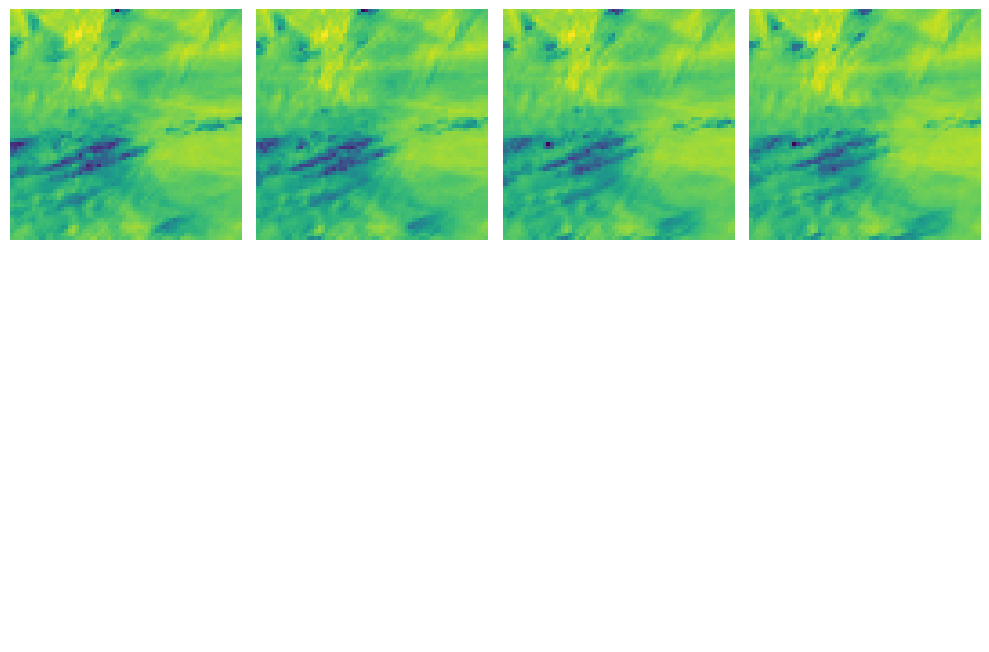

learning_rate,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_mse,█▇▅▂▁▂▁▁▁▁
learning_rate,0.0
train_mse,nan


In [ ]:
with wandb.init(project=PROJECT_NAME, entity='ai-industry', config=config, tags=["ddpm", config.model_name]):
    train_func(config, train_ds, train_ds)

In [ ]:
with wandb.init(project='3d_unet', entity='ai-industry', config=config, tags=["ddpm", config.model_name]):
    save_model(model, 'unet3d')

#Validation

In [ ]:
# sampler
sampler = ddim_sampler(steps=100)

In [ ]:
model

In [ ]:
def load_model(model_name):
    "Load the model from wandb"
    run = wandb.init()
    artifact = run.use_artifact(model_name, type='model')
    artifact_dir = artifact.download()
    wandb.finish()

In [ ]:
load_model('ai-industry/3d_unet/lk8qsufz_unet3d:v0')

In [ ]:
checkpoint = torch.load('/content/artifacts/lk8qsufz_unet3d:v0/lk8qsufz_unet3d.pth')
model.load_state_dict(checkpoint)

In [ ]:
model.cuda()

In [ ]:
val_batch = next(iter(train_dataloader))

In [ ]:
val_batch[0].shape

In [ ]:
val_past_frames, future_frames, t, _ = to_device(val_batch, device='cuda')

In [ ]:
val_past_frames = val_past_frames[11:12]  # log first 2 predictions
samples = sampler(model, past_frames=val_past_frames)

In [ ]:
t[11:12]

In [ ]:
import matplotlib.pyplot as plt
axs = plt.subplots(3, 4, figsize=(10, 10))[1].ravel()
i=0
for ax in axs:
    if i < 4:
        ax.imshow(val_past_frames[0,i,0].cpu())
    elif i < 8:
        ax.imshow(samples[0,i-4].detach().cpu())
    else:
        ax.imshow(future_frames[11,i-8].detach().cpu())
    ax.axis('off')
    i+=1
plt.show()    